The challenge is to develop a ML model to predict the number of vehicles in an accident.

Notes:

* The task must be worked following the CRISP-DM methodology.
* The technical process must be clear to understand which steps have been done to get the final model.
* There must be a presentation to show the business value and the conclusions you get from the development.
* Any assumption on business value or data info can be done, but they should be commented and explained on the presentation.
* One week to resolve this challenge.

In [91]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from pycaret.regression import *
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import datetime

In [2]:
accidents = pd.read_csv('data/Accidents2016.csv')
accidents.shape

(136621, 32)

In [5]:
accidents.dtypes

Accident_Index                                  object
Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                    float64
Junction_D

# Feature engineering
1. Convert Date and Time to timestamp and create hour, month, period of day, day of week and season attributes
2. Split and convert to numerical and categorical columns and create plots

In [70]:
df = accidents.copy()

In [4]:
def convertToDatetime(df:pd.DataFrame):
    if all(item in df.columns for item in ['Date', 'Time']) and 'Datetime' not in df.columns:
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M', errors='coerce')
        df.drop(['Date', 'Time'], axis=1, inplace=True)
        #df.dropna(subset=['Datetime'], inplace=True)

def mapHours(hour:int) -> str:
    if hour < 6:
        return 'Early morning'
    elif hour < 10:
        return 'Morning commute'
    elif hour < 13:
        return 'Morning'
    elif hour < 16:
        return 'Afternoon'
    elif hour < 19:
        return 'Afternoon commute'
    elif hour < 23:
        return 'Evening'
    else:
        return 'Night'
    
def mapMonths(month:int) -> str:
    if month < 3:
        return 'Winter'
    elif month < 6:
        return 'Spring'
    elif month < 9:
        return 'Summer'
    elif month < 12:
        return 'Autumn'
    else:
        return 'Winter'
    
def generateFeaturesFromDatetime(df:pd.DataFrame):
    if 'Datetime' in df.columns:
        df['Hour'] = pd.Categorical(df['Datetime'].dt.hour)
        df['Month'] = pd.Categorical(df['Datetime'].dt.month)
        df['Period_of_Day'] = pd.Categorical(df['Hour'].map(mapHours))
        df['Season'] = pd.Categorical(df['Month'].map(mapMonths))
        
def convertToCategorical(df:pd.DataFrame, cols:list):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        
def dropColumns(df:pd.DataFrame, cols:list):
    df.drop(cols, axis=1, inplace=True)
    
def mapNumbersToDefinitions(df:pd.DataFrame, colMapping: dict) -> pd.DataFrame:
    new_df = df.copy()
    for col, mapping in columns_mapping.items():
        new_df[col] = df[col].map(mapping)
    return new_df

In [5]:
#Not sure -> '1st_Road_Number', '2nd_Road_Number', 'Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'
categorical_cols = ['Police_Force', 'Accident_Severity', 'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Speed_limit', 
                    'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control',
                    'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 
                    'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
                   'Did_Police_Officer_Attend_Scene_of_Accident']
numerical_cols = ['Number_of_Casualties']

In [99]:
df.dtypes

Accident_Index                                  object
Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                    float64
Junction_D

In [71]:
convertToDatetime(df)
generateFeaturesFromDatetime(df)
#convertToCategorical(df, categorical_cols)

In [72]:
df.dtypes

Accident_Index                                         object
Location_Easting_OSGR                                 float64
Location_Northing_OSGR                                float64
Longitude                                             float64
Latitude                                              float64
Police_Force                                            int64
Accident_Severity                                       int64
Number_of_Vehicles                                      int64
Number_of_Casualties                                    int64
Day_of_Week                                             int64
Local_Authority_(District)                              int64
Local_Authority_(Highway)                              object
1st_Road_Class                                          int64
1st_Road_Number                                         int64
Road_Type                                               int64
Speed_limit                                           float64
Junction

In [73]:
df = df[df['Datetime'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136619 entries, 0 to 136620
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Accident_Index                               136619 non-null  object        
 1   Location_Easting_OSGR                        136612 non-null  float64       
 2   Location_Northing_OSGR                       136612 non-null  float64       
 3   Longitude                                    136612 non-null  float64       
 4   Latitude                                     136612 non-null  float64       
 5   Police_Force                                 136619 non-null  int64         
 6   Accident_Severity                            136619 non-null  int64         
 7   Number_of_Vehicles                           136619 non-null  int64         
 8   Number_of_Casualties                         136619 non-null  in

# EDA

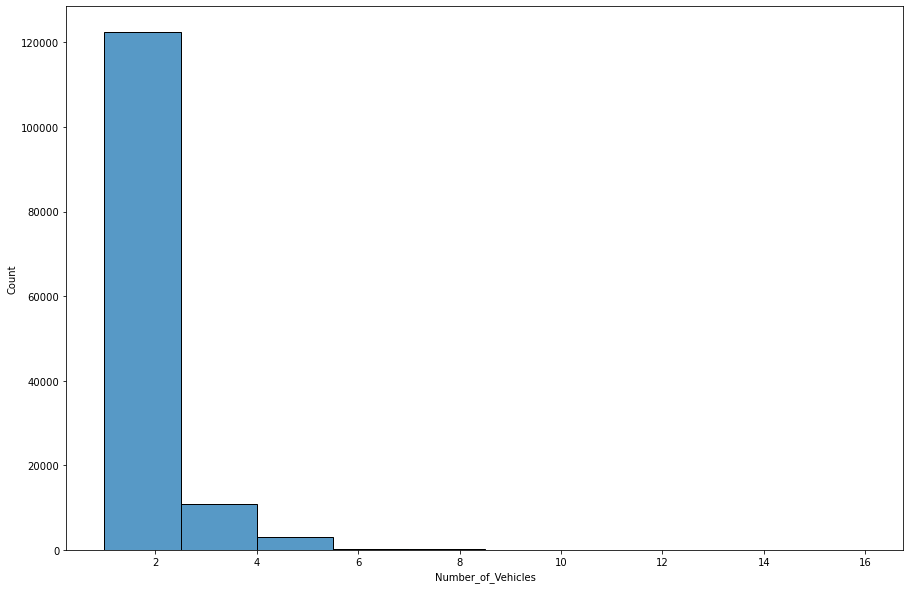

In [112]:
plt.figure(figsize=(15,10))
sns.histplot(df['Number_of_Vehicles'], bins=10);

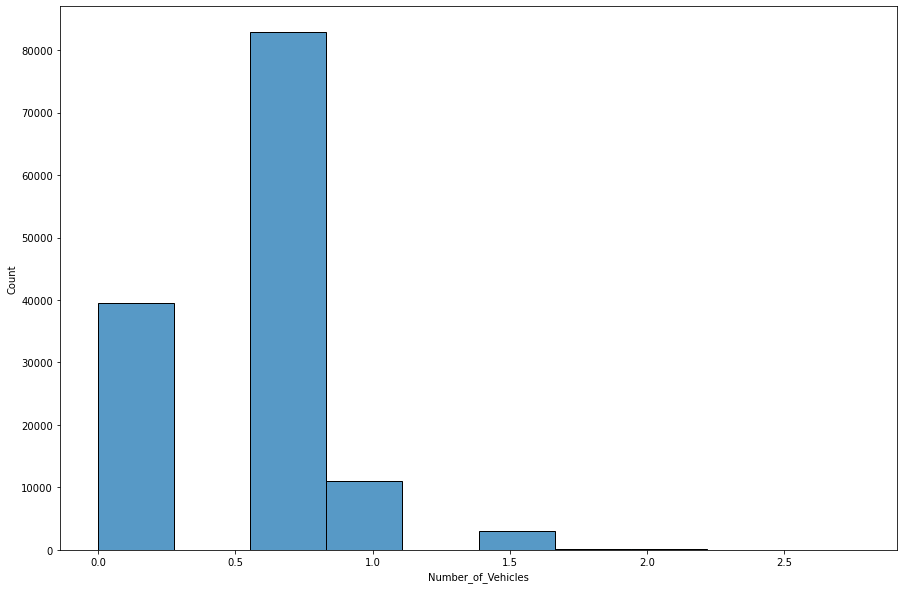

In [113]:
plt.figure(figsize=(15,10))
sns.histplot(np.log(df['Number_of_Vehicles']), bins=10);

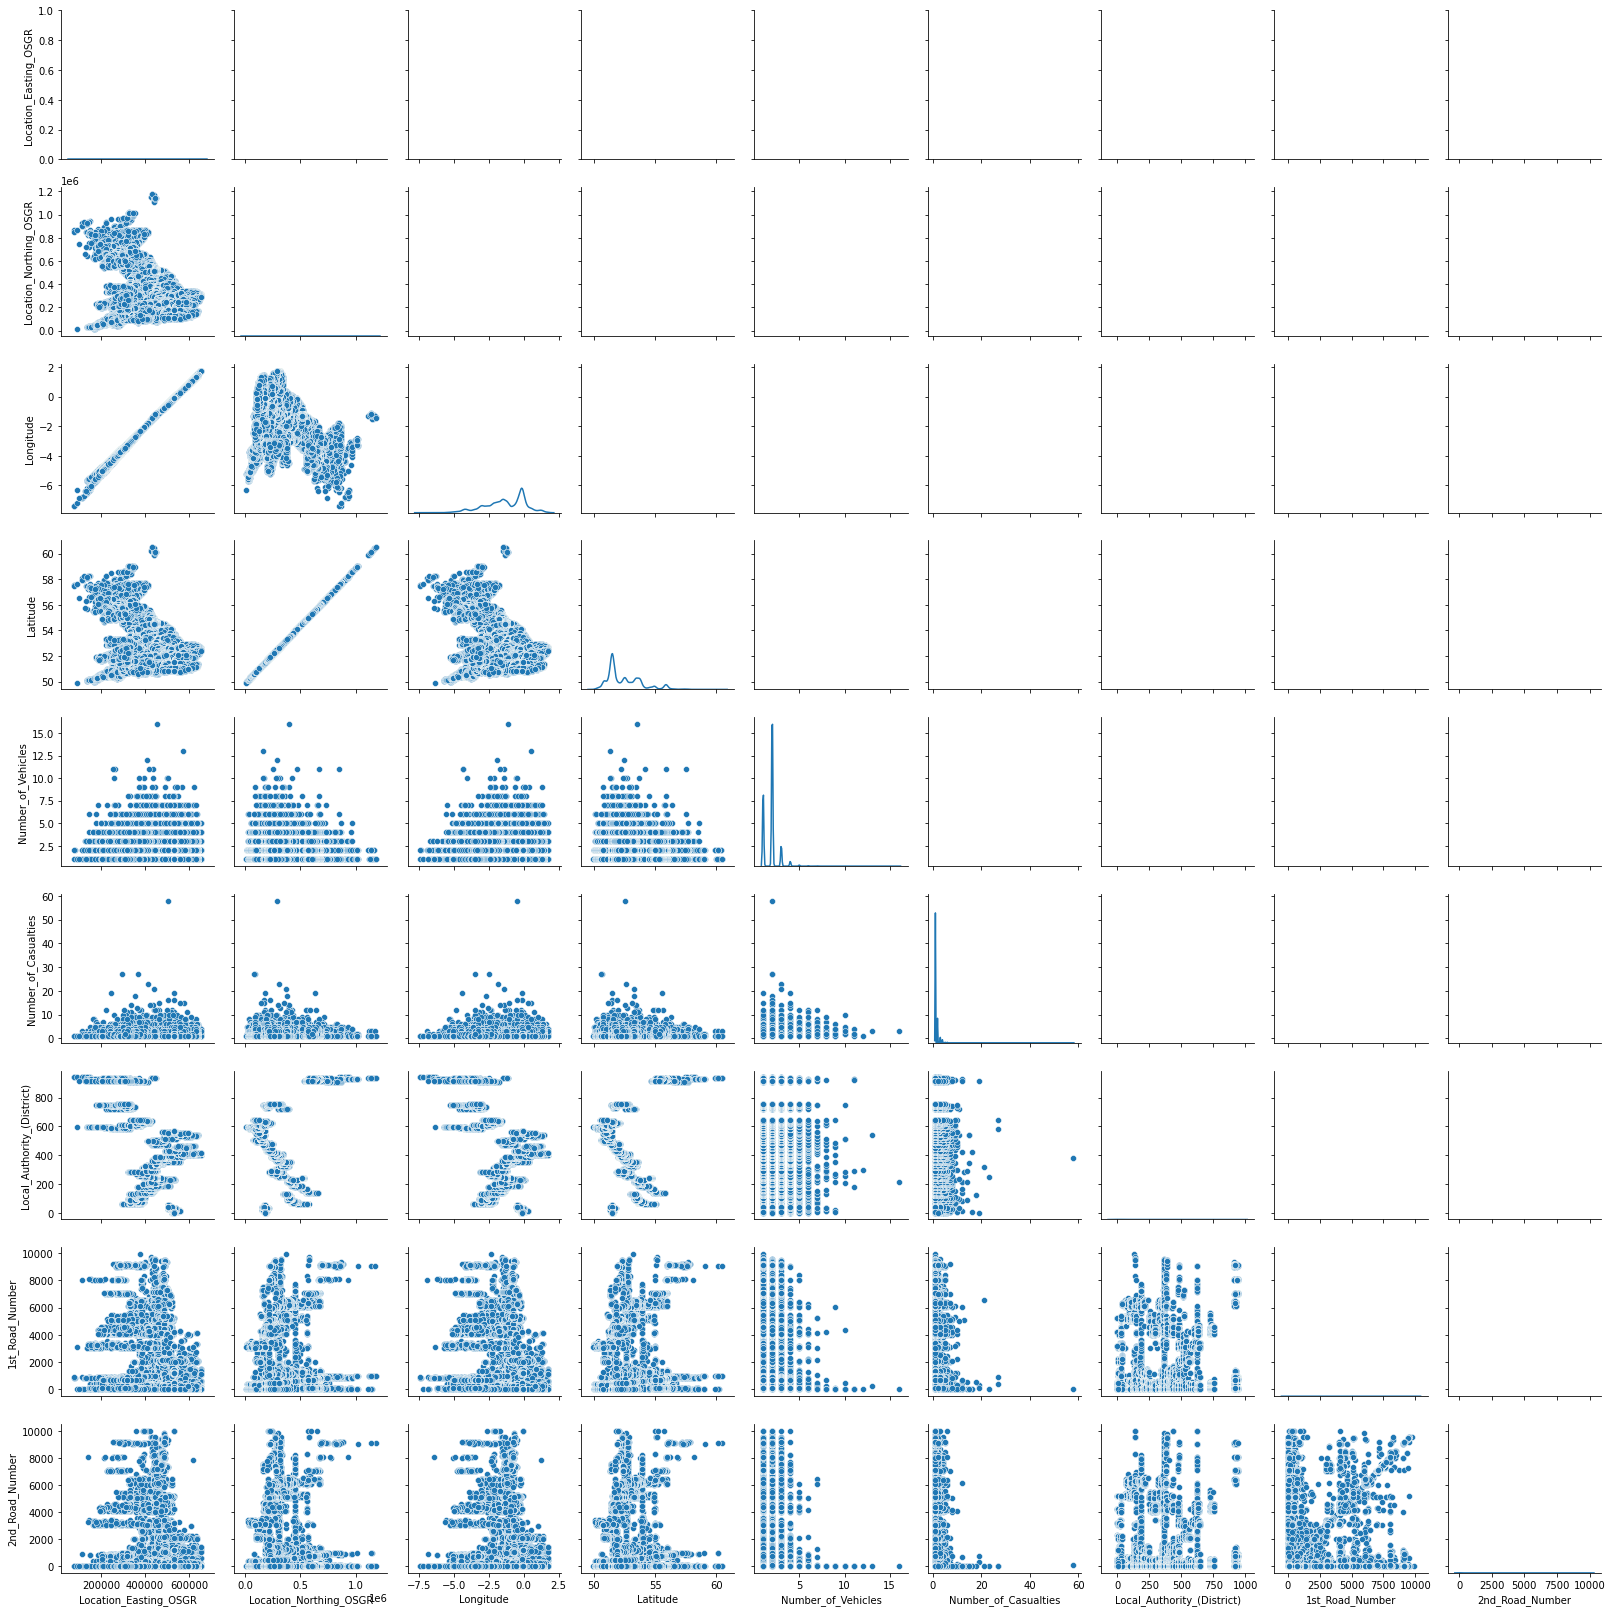

In [109]:
g = sns.PairGrid(df)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
plt.tight_layout()
plt.show()

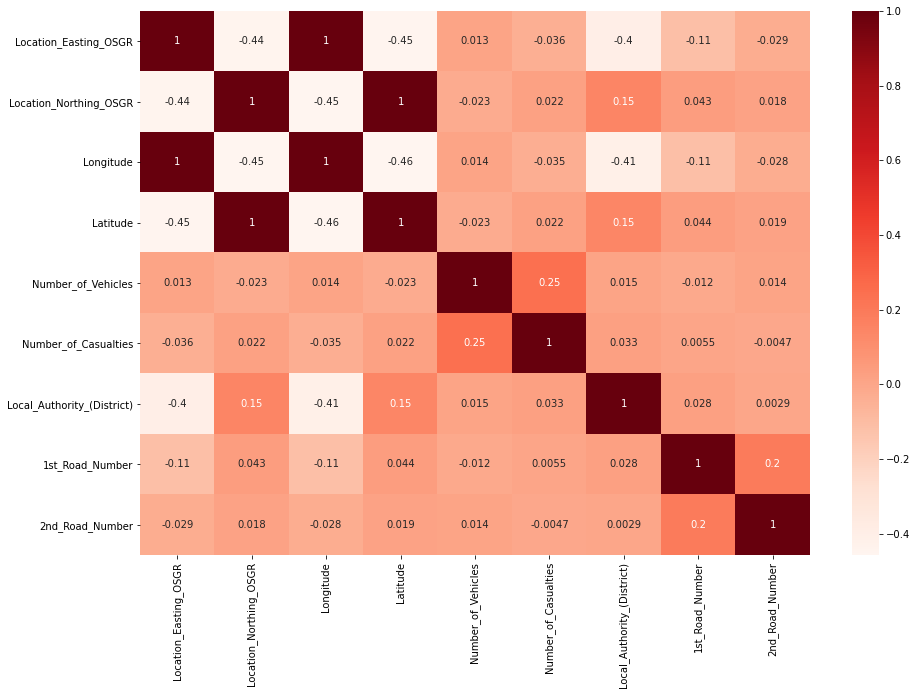

In [110]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds);

## Map numbers to strings for plots

In [121]:
columns_mapping = {'Accident_Severity': {1: 'Fatal',
                                        2: 'Serious',
                                        3: 'Slight'},
                  'Day_of_Week': {1: 'Sunday',
                                 2: 'Monday',
                                 3: 'Tuesday',
                                 4: 'Wednesday',
                                 5: 'Thursday',
                                 6: 'Friday',
                                 7: 'Saturday'},
                  '1st_Road_Class': {1: 'Motorway',
                                    2: 'A(M)',
                                    3: 'A',
                                    4: 'B',
                                    5: 'C',
                                    6: 'Unassigned'},
                  'Road_Type': {-1: np.nan,
                               1: 'Roundabout',
                               2: 'One way street',
                               3: 'Dual carriageway',
                               6: 'Single carriageway',
                               7: 'Slip Road',
                               9: 'Unknown'},
                  'Junction_Detail': {-1: np.nan,
                                     0: 'Not at or within 20 metres of junction',
                                     1: 'Roundabout',
                                     2: 'Mini roundabout',
                                     3: 'T or staggered junction',
                                     5: 'Slip road',
                                     6: 'Crossroads',
                                     7: 'Multiple junction',
                                     8: 'Using private drive or entrance',
                                     9: 'Other junction'},
                  'Junction_Control': {-1: np.nan,
                                      0: np.nan,
                                      1: 'Authorised person',
                                      2: 'Automatic traffic singal',
                                      3: 'Stop sign',
                                      4: 'Give way or uncontrolled'},
                  '2nd_Road_Class': {-1: np.nan,
                                    1: 'Motorway',
                                    2: 'A(M)',
                                    3: 'A',
                                    4: 'B',
                                    5: 'C',
                                    6: 'Unassigned'},
                  'Pedestrian_Crossing-Human_Control': {-1: np.nan,
                                                       0: 'None within 50 metres',
                                                       1: 'Control by school crossing patrol',
                                                       2: 'Control by other authorised person'},
                  'Pedestrian_Crossing-Physical_Facilities': {-1: np.nan,
                                                             0: 'No physical crossing facility within 50 metres',
                                                             1: 'Zebra crossing',
                                                             4: 'Pelican, puffin, toucan or similar non-junction pedestrian light crossing',
                                                             5: 'Pedestrian phase at traffic signal junction',
                                                             7: 'Footbridge or subway',
                                                             8: 'Ceentral refuge - no other controls'},
                  'Light_Conditions': {-1: np.nan,
                                     1: 'Daylight: street lights present',
                                     2: 'Daylight: no street lighting',
                                     3: 'Daylight: street lighting unknown',
                                     4: 'Darkness: street lights present and lit',
                                     5: 'Darkness: street lights present but unlit',
                                     6: 'Darkness: no street lighting',
                                     7: 'Darkness: street lighting unknown'},
                  'Weather_Conditions': {-1: np.nan,
                                        1: 'Fine without high winds',
                                        2: 'Raining without high winds',
                                        3: 'Snowing without high winds',
                                        4: 'Fine with high winds',
                                        5: 'Raining with high winds',
                                        6: 'Snowing with high winds',
                                        7: 'Fog or mist - if hazard',
                                        8: 'Other',
                                        9: 'Unknown'},
                  'Road_Surface_Conditions': {-1: np.nan,
                                          1: 'Dry',
                                          2: 'Wet/Damp',
                                          3: 'Snow',
                                          4: 'Frost/Ice',
                                          5: 'Flood'},
                  'Special_Conditions_at_Site': {-1: np.nan,
                                                0: 'None',
                                                1: 'Automatic traffic signal out',
                                                2: 'Automatic traffic signal partially defective',
                                                3: 'Permament road signing or marking defective or obscured',
                                                4: 'Roadworks',
                                                5: 'Road surface defective',
                                                6: 'Oil or diesel',
                                                7: 'Mud'},
                  'Carriageway_Hazards': {-1: np.nan,
                                         0: 'None',
                                         1: 'Dislodged vehicle load in carriageway',
                                         2: 'Other object in carriageway',
                                         3: 'Involvement with previous accident',
                                         6: 'Pedestrian in carriageway - not injured',
                                         7: 'Any animal in carriageway'},
                  'Urban_or_Rural_Area': {1: 'Urban',
                                         2: 'Rural',
                                         3: 'Unallocated'},
                  'Did_Police_Officer_Attend_Scene_of_Accident': {-1: np.nan,
                                                                 1: 'Yes',
                                                                 2: 'No', 
                                                                 3: 'No - accident was reported using a self completion form'}}

In [122]:
descriptive_df = mapNumbersToDefinitions(df, columns_mapping)
descriptive_df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Datetime,Hour,Month,Period_of_Day,Season
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,Slight,2,1,Tuesday,28,E09000005,A,4006,Single carriageway,30.0,Not at or within 20 metres of junction,NaN,NaN,0,None within 50 metres,No physical crossing facility within 50 metres,Darkness: street lights present but unlit,Fine without high winds,Dry,None,None,Urban,Yes,E01000543,2016-11-01 02:30:00,2.0,11.0,Early morning,Autumn
1,2016010000006,551920.0,174560.0,0.184928,51.449595,1,Slight,1,1,Tuesday,18,E09000004,A,207,Single carriageway,30.0,Other junction,Give way or uncontrolled,Unassigned,0,None within 50 metres,No physical crossing facility within 50 metres,Darkness: street lights present and lit,Fine without high winds,Dry,None,None,Urban,Yes,E01000375,2016-11-01 00:37:00,0.0,11.0,Early morning,Autumn
2,2016010000008,505930.0,183850.0,-0.473837,51.543563,1,Slight,1,1,Tuesday,26,E09000017,A,4020,Roundabout,30.0,Roundabout,Give way or uncontrolled,A,4020,None within 50 metres,No physical crossing facility within 50 metres,Darkness: street lights present and lit,Fine without high winds,Dry,None,None,Urban,Yes,E01033725,2016-11-01 01:25:00,1.0,11.0,Early morning,Autumn
3,2016010000016,527770.0,168930.0,-0.164442,51.404958,1,Slight,1,1,Tuesday,22,E09000024,A,217,Single carriageway,30.0,T or staggered junction,Automatic traffic singal,A,217,None within 50 metres,No physical crossing facility within 50 metres,Daylight: street lights present,Fine without high winds,Dry,None,None,Urban,Yes,E01003379,2016-11-01 09:15:00,9.0,11.0,Morning commute,Autumn
4,2016010000018,510740.0,177230.0,-0.406580,51.483139,1,Slight,2,1,Tuesday,25,E09000018,A,312,Dual carriageway,40.0,Not at or within 20 metres of junction,NaN,NaN,0,None within 50 metres,No physical crossing facility within 50 metres,Daylight: street lights present,Fine without high winds,Dry,None,None,Urban,Yes,E01002583,2016-11-01 07:53:00,7.0,11.0,Morning commute,Autumn


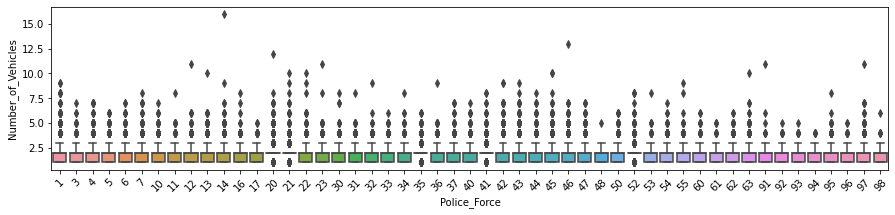

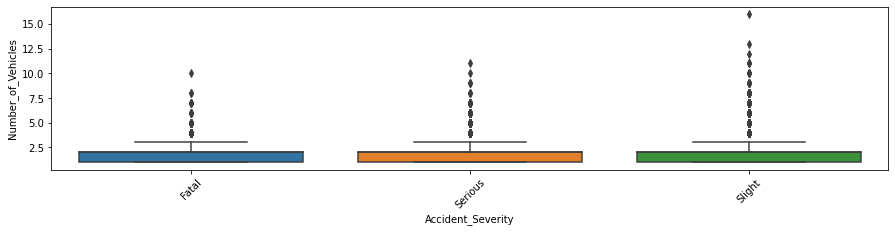

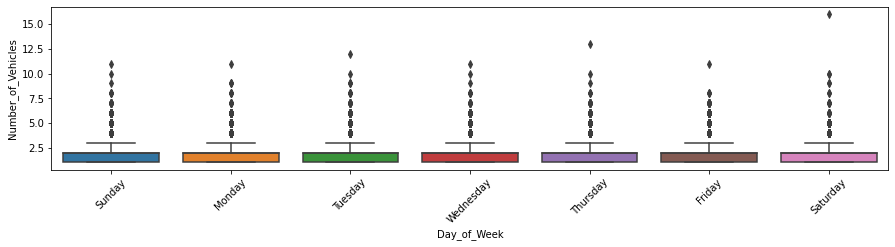

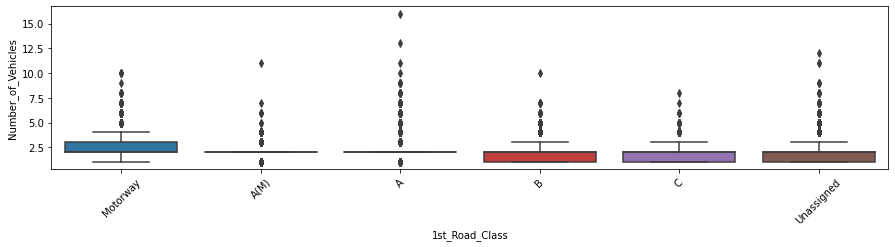

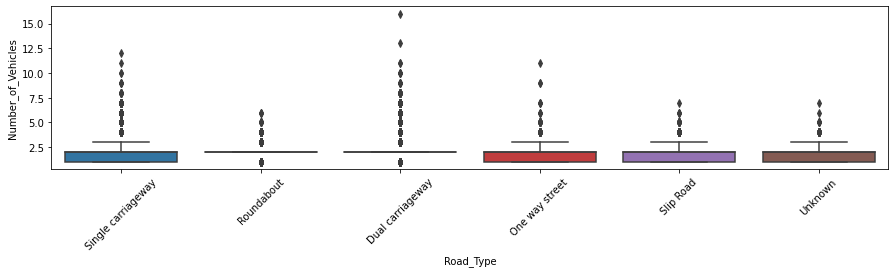

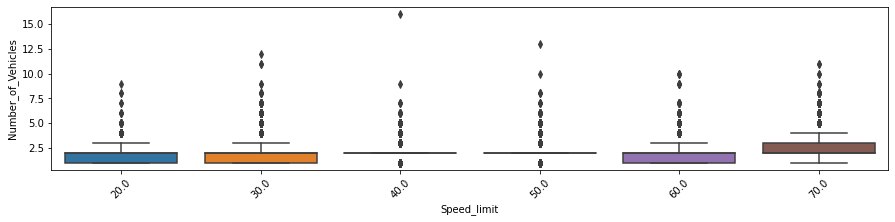

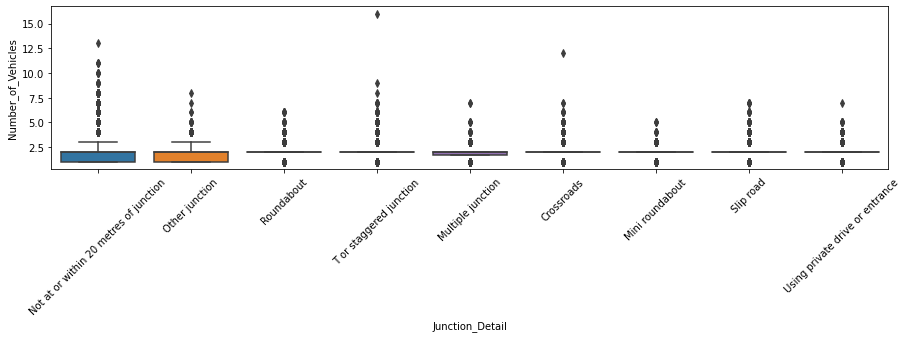

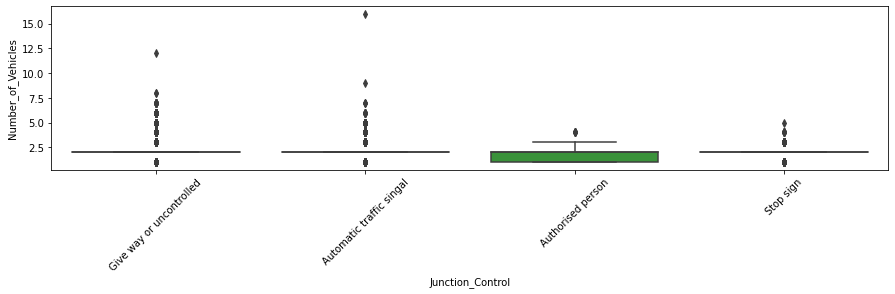

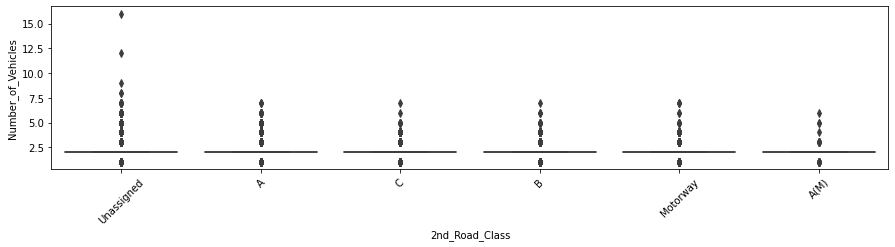

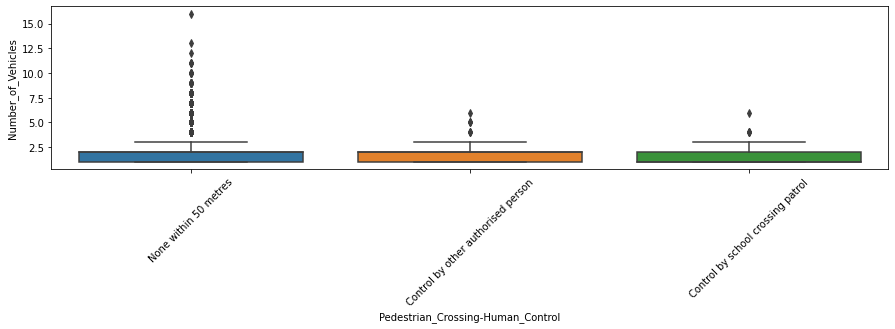

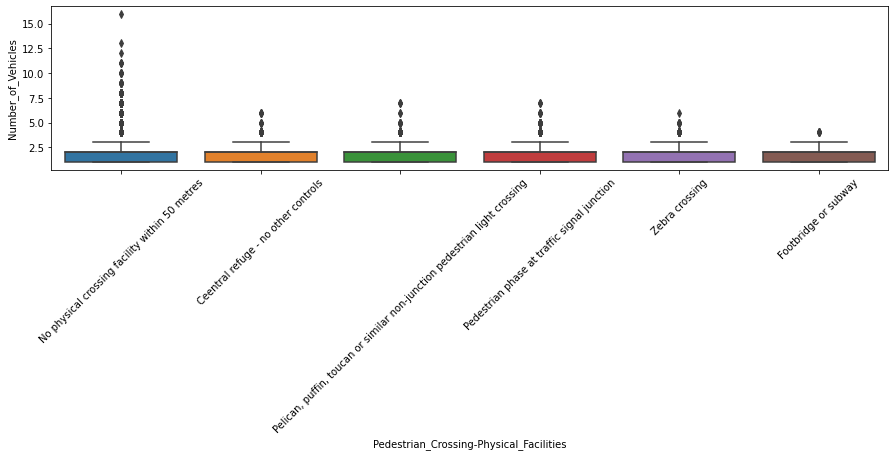

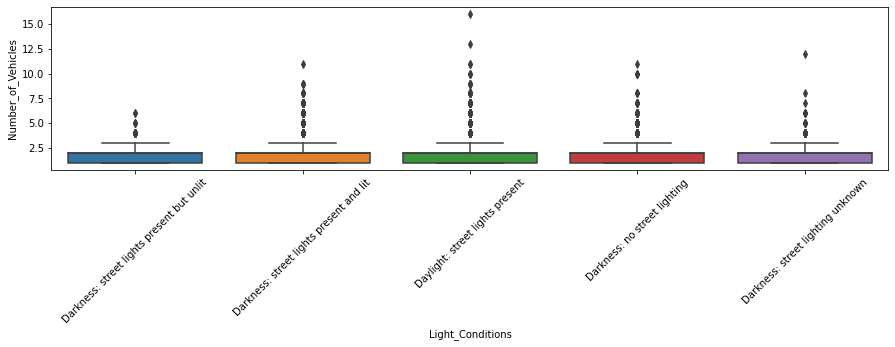

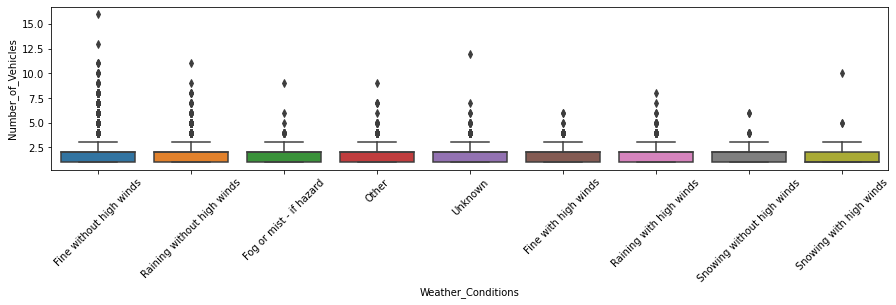

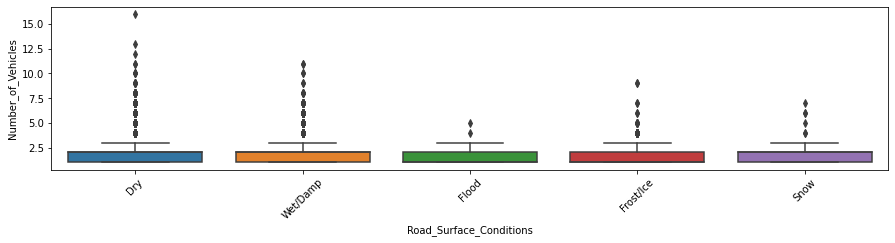

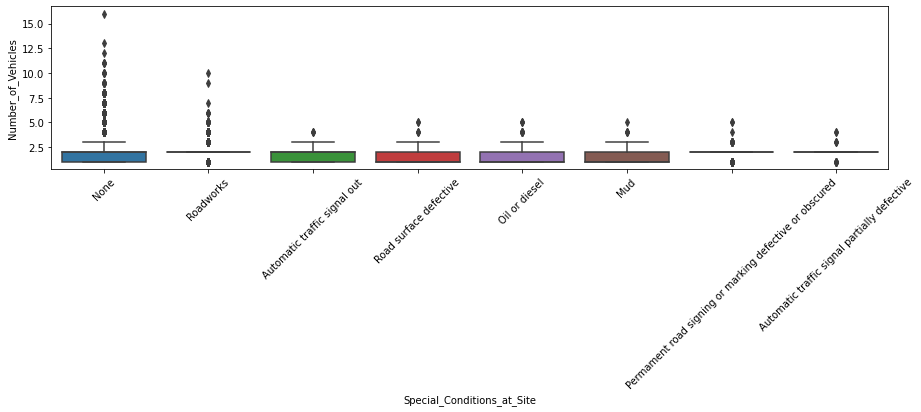

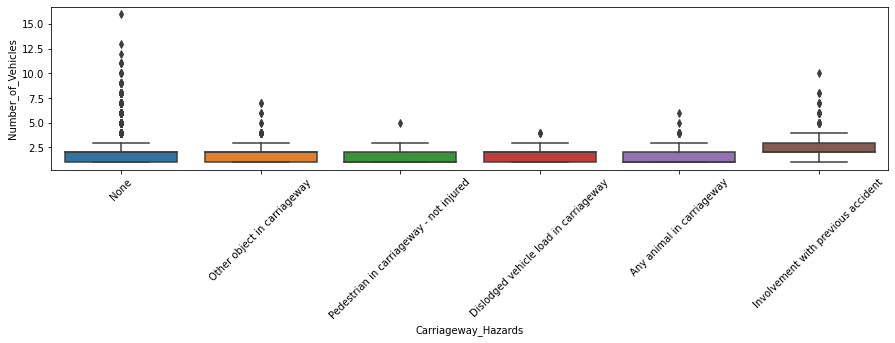

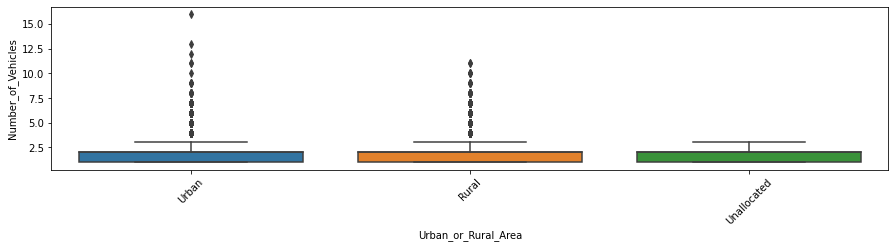

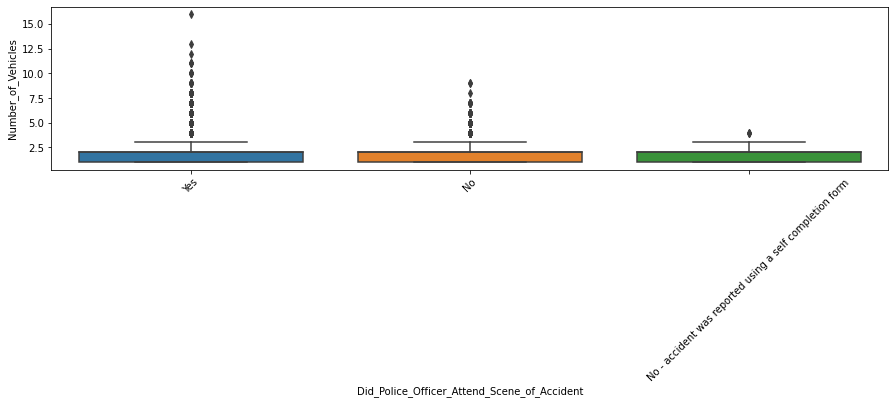

In [124]:
for col in categorical_cols:
    plt.figure(figsize=(15,3))
    ax = sns.boxplot(x=descriptive_df[col], y=descriptive_df['Number_of_Vehicles'])
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.show();

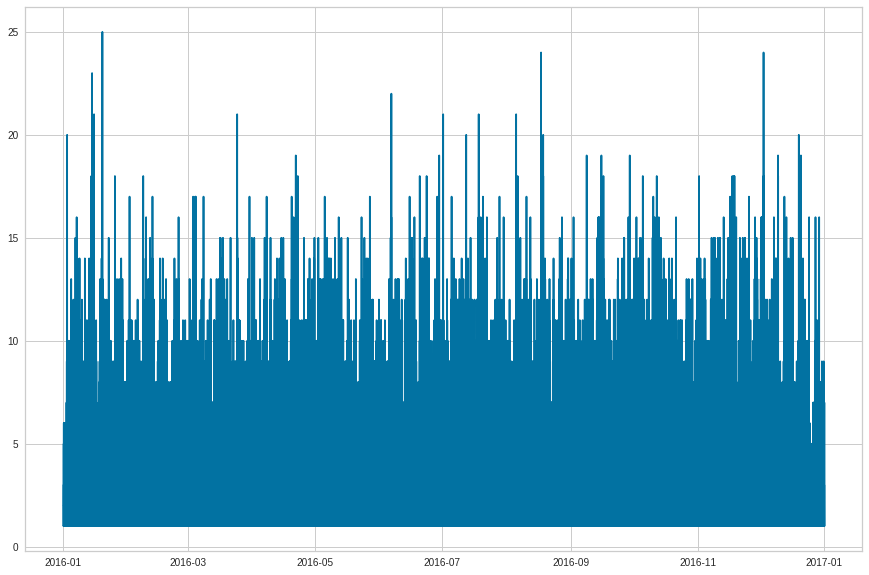

In [98]:
grouped_df = df[['Datetime', 'Number_of_Vehicles']].groupby('Datetime').sum().reset_index()
x = grouped_df.loc[:, 'Datetime']
y = grouped_df.loc[:, 'Number_of_Vehicles']
plt.figure(figsize=(15,10))
plt.plot(x,y);

In [95]:
df[['Datetime', 'Number_of_Vehicles']].groupby('Datetime').sum().reset_index()

,Datetime,Number_of_Vehicles
0,2016-01-01 00:01:00,1
1,2016-01-01 00:02:00,1
2,2016-01-01 00:05:00,1
3,2016-01-01 00:11:00,2
4,2016-01-01 00:15:00,3
...,...,...
92891,2016-12-31 23:35:00,1
92892,2016-12-31 23:45:00,3
92893,2016-12-31 23:46:00,4
92894,2016-12-31 23:50:00,1


## Model Development with Pycaret

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136621 entries, 0 to 136620
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Accident_Index                               136621 non-null  object        
 1   Location_Easting_OSGR                        136614 non-null  float64       
 2   Location_Northing_OSGR                       136614 non-null  float64       
 3   Longitude                                    136614 non-null  float64       
 4   Latitude                                     136614 non-null  float64       
 5   Police_Force                                 136621 non-null  category      
 6   Accident_Severity                            136621 non-null  category      
 7   Number_of_Vehicles                           136621 non-null  int64         
 8   Number_of_Casualties                         136621 non-null  in

In [9]:
setup(df, 
      target='Number_of_Vehicles',
      ignore_features = ['Accident_Index',
                        'Location_Easting_OSGR',
                        'Location_Northing_OSGR',
                        'Day_of_Week',
                        'Hour',
                        'Month',
                        'Period_of_Day',
                        'Season'
                        ],
     categorical_features=['1st_Road_Number',
                          '2nd_Road_Number',
                          'Local_Authority_(District)'],
      numeric_features=['Number_of_Casualties'],
     normalize=True,
     normalize_method='robust',
    high_cardinality_features=['Local_Authority_(District)',
                             'Local_Authority_(Highway)',
                             '1st_Road_Number',
                             '2nd_Road_Number',
                             'LSOA_of_Accident_Location'],
     high_cardinality_method='frequency'
     )

,Description,Value
0,session_id,6433
1,Target,Number_of_Vehicles
2,Original Data,"(136619, 35)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,22
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(95633, 204)"


([<pandas.io.formats.style.Styler at 0x7fc4c92e33a0>],
 'lightgbm',
 [],
 False,
 'lightgbm',
 <MLUsecase.REGRESSION: 2>,
 None,
 128658    1
 38252     1
 101467    2
 90324     1
 8156      1
          ..
 57225     3
 67718     2
 60914     2
 132660    1
 32636     2
 Name: Number_of_Vehicles, Length: 95633, dtype: object,
 'b111',
 KFold(n_splits=10, random_state=6433, shuffle=False),
 [('Setup Config',
                                  Description               Value
   0                               session_id                6433
   1                                   Target  Number_of_Vehicles
   2                            Original Data        (136619, 35)
   3                           Missing Values                True
   4                         Numeric Features                   3
   5                     Categorical Features                  22
   6                         Ordinal Features               False
   7                High Cardinality Features               

In [10]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4613,0.4243,0.6513,0.1687,0.0000,0.3020,7.8150
xgboost,Extreme Gradient Boosting,0.4656,0.4343,0.6590,0.1490,0.0000,0.3044,114.7860
gbr,Gradient Boosting Regressor,0.4687,0.4362,0.6604,0.1453,0.0000,0.3109,8.4590
ridge,Ridge Regression,0.4702,0.4405,0.6636,0.1370,0.0000,0.3094,0.1000
br,Bayesian Ridge,0.4703,0.4405,0.6636,0.1369,0.0000,0.3097,1.6840
lr,Linear Regression,0.4704,0.4409,0.6639,0.1362,0.0000,0.3095,0.7210
rf,Random Forest Regressor,0.4754,0.4475,0.6689,0.1231,0.0000,0.3116,56.2310
omp,Orthogonal Matching Pursuit,0.4760,0.4492,0.6701,0.1199,0.0000,0.3149,0.2520
huber,Huber Regressor,0.4914,0.4884,0.6985,0.0435,0.0000,0.3222,12.8790
et,Extra Trees Regressor,0.5008,0.5083,0.7129,0.0040,0.0000,0.3210,91.6120


In [11]:
CBR = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4619,0.4262,0.6529,0.1671,-0.0000,0.2991
1,0.4566,0.4053,0.6366,0.1877,-0.0000,0.3016
2,0.4600,0.4090,0.6395,0.1757,-0.0000,0.3013
3,0.4611,0.4162,0.6451,0.1690,-0.0000,0.3067
4,0.4572,0.4372,0.6612,0.1601,-0.0000,0.2956
5,0.4676,0.4398,0.6632,0.1712,-0.0000,0.3050
6,0.4644,0.4287,0.6547,0.1624,-0.0000,0.3023
7,0.4621,0.4278,0.6541,0.1606,-0.0000,0.3024
8,0.4581,0.4129,0.6426,0.1660,-0.0000,0.3062
9,0.4639,0.4400,0.6633,0.1667,-0.0000,0.3000


In [12]:
tuned_CBR = tune_model(CBR,n_iter = 50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4637,0.4266,0.6531,0.1664,-0.0000,0.3025
1,0.4598,0.4101,0.6404,0.1780,-0.0000,0.3052
2,0.4628,0.4126,0.6423,0.1684,-0.0000,0.3054
3,0.4636,0.4196,0.6478,0.1622,-0.0000,0.3101
4,0.4611,0.4419,0.6647,0.1512,-0.0000,0.3007
5,0.4711,0.4458,0.6677,0.1599,-0.0000,0.3091
6,0.4684,0.4326,0.6577,0.1546,-0.0000,0.3066
7,0.4634,0.4259,0.6526,0.1643,-0.0000,0.3054
8,0.4614,0.4178,0.6464,0.1560,-0.0000,0.3109
9,0.4669,0.4455,0.6675,0.1562,-0.0000,0.3039


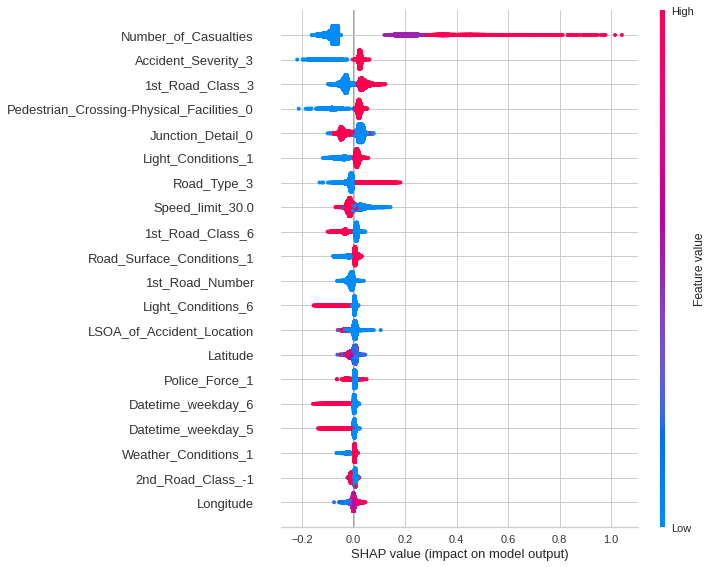

In [17]:
interpret_model(tuned_CBR)

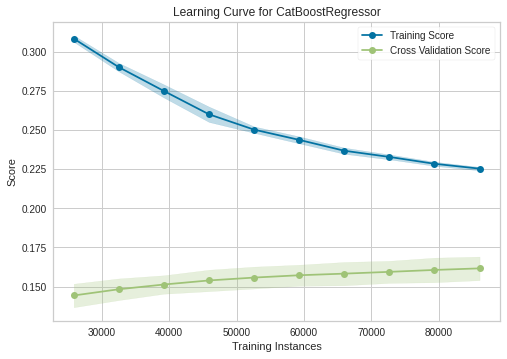

In [33]:
plot_model(tuned_CBR, 'learning')

IntProgress(value=0, description='Processing: ', max=5)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

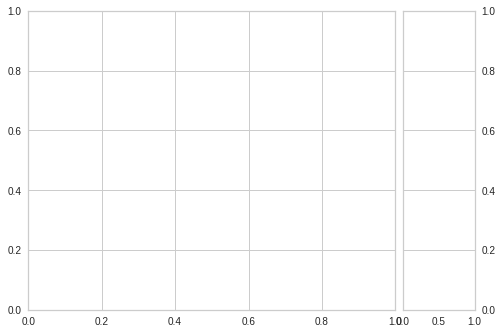

In [69]:
plot_model(tuned_CBR, 'residuals')

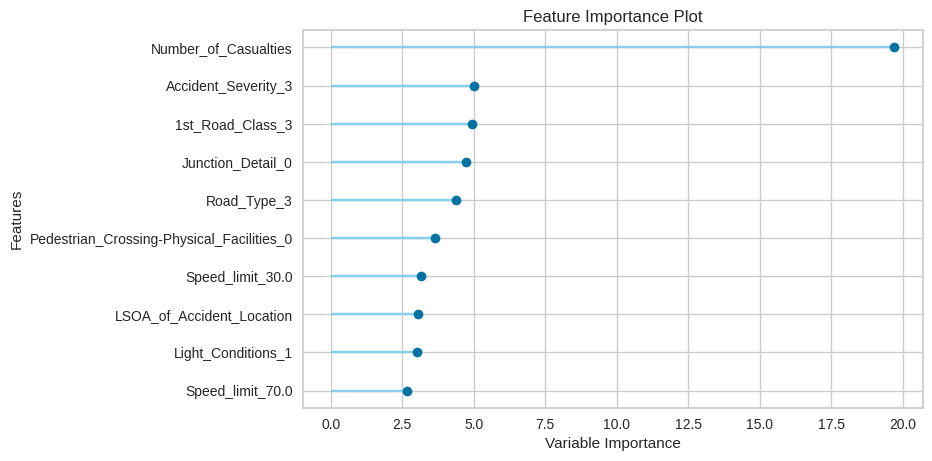

In [34]:
plot_model(tuned_CBR, 'feature')

In [19]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4725,0.4417,0.6646,0.1369,-0.0000,0.3077
1,0.4652,0.4246,0.6516,0.1490,-0.0000,0.3081
2,0.4702,0.4288,0.6549,0.1356,-0.0000,0.3091
3,0.4704,0.4318,0.6571,0.1378,-0.0000,0.3139
4,0.4665,0.4531,0.6731,0.1296,-0.0000,0.3036
5,0.4781,0.4609,0.6789,0.1315,-0.0000,0.3129
6,0.4726,0.4431,0.6656,0.1342,-0.0000,0.3089
7,0.4692,0.4382,0.6620,0.1403,-0.0000,0.3092
8,0.4676,0.4289,0.6549,0.1336,-0.0000,0.3144
9,0.4721,0.4577,0.6766,0.1331,-0.0000,0.3070


In [20]:
tuned_lr = tune_model(lr,n_iter = 50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4725,0.4417,0.6646,0.1369,-0.0000,0.3077
1,0.4652,0.4246,0.6516,0.1490,-0.0000,0.3081
2,0.4702,0.4288,0.6549,0.1356,-0.0000,0.3091
3,0.4704,0.4318,0.6571,0.1378,-0.0000,0.3139
4,0.4665,0.4531,0.6731,0.1296,-0.0000,0.3036
5,0.4781,0.4609,0.6789,0.1315,-0.0000,0.3129
6,0.4726,0.4431,0.6656,0.1342,-0.0000,0.3089
7,0.4692,0.4382,0.6620,0.1403,-0.0000,0.3092
8,0.4676,0.4289,0.6549,0.1336,-0.0000,0.3144
9,0.4721,0.4577,0.6766,0.1331,-0.0000,0.3070


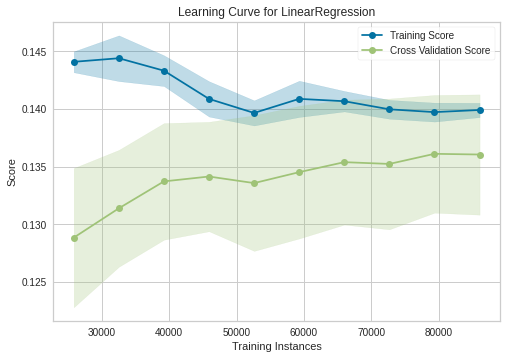

In [29]:
plot_model(tuned_lr, 'learning')

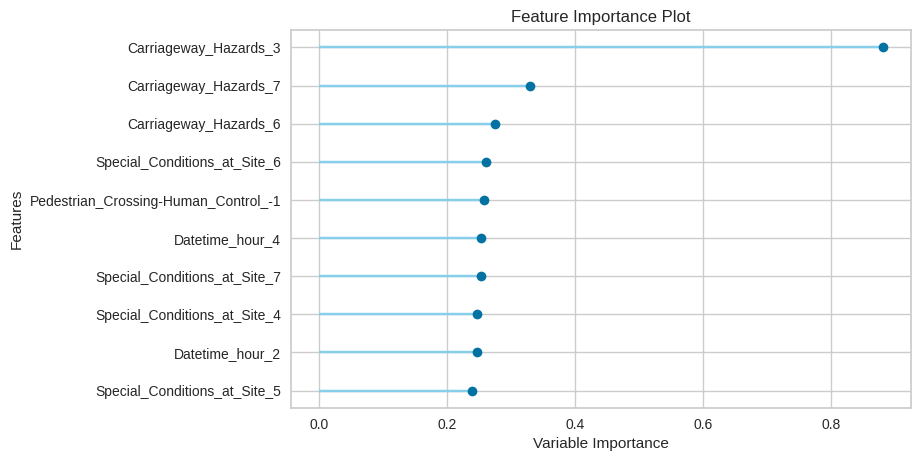

In [32]:
plot_model(tuned_lr, 'feature')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136619 entries, 0 to 136620
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Accident_Index                               136619 non-null  object        
 1   Location_Easting_OSGR                        136612 non-null  float64       
 2   Location_Northing_OSGR                       136612 non-null  float64       
 3   Longitude                                    136612 non-null  float64       
 4   Latitude                                     136612 non-null  float64       
 5   Police_Force                                 136619 non-null  int64         
 6   Accident_Severity                            136619 non-null  int64         
 7   Number_of_Vehicles                           136619 non-null  int64         
 8   Number_of_Casualties                         136619 non-null  in

In [76]:
setup(df, 
      target='Number_of_Vehicles',
      ignore_features = ['Accident_Index',
                        'Location_Easting_OSGR',
                        'Location_Northing_OSGR',
                        'Day_of_Week',
                        'Hour',
                        'Month',
                        'Period_of_Day',
                        'Season'
                        ],
     categorical_features=['1st_Road_Number',
                          '2nd_Road_Number',
                          'Local_Authority_(District)',
                          'Police_Force'],
      numeric_features=['Number_of_Casualties'],
     normalize=True,
     normalize_method='robust',
    high_cardinality_features=['Local_Authority_(District)',
                             'Local_Authority_(Highway)',
                             '1st_Road_Number',
                             '2nd_Road_Number',
                             'LSOA_of_Accident_Location'],
     high_cardinality_method='frequency'
     )

,Description,Value
0,session_id,4093
1,Target,Number_of_Vehicles
2,Original Data,"(136619, 35)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,22
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(95633, 204)"


([<pandas.io.formats.style.Styler at 0x7fc584a12910>],
 'lightgbm',
 [],
 False,
 'lightgbm',
 <MLUsecase.REGRESSION: 2>,
 None,
 52588     1
 57091     1
 75118     2
 99774     3
 68011     3
          ..
 60901     4
 94324     2
 33740     1
 118530    1
 39619     2
 Name: Number_of_Vehicles, Length: 95633, dtype: object,
 '37ce',
 KFold(n_splits=10, random_state=4093, shuffle=False),
 [('Setup Config',
                                  Description               Value
   0                               session_id                4093
   1                                   Target  Number_of_Vehicles
   2                            Original Data        (136619, 35)
   3                           Missing Values                True
   4                         Numeric Features                   3
   5                     Categorical Features                  22
   6                         Ordinal Features               False
   7                High Cardinality Features               

In [77]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4618,0.4219,0.6495,0.1633,0.0000,0.3029,9.4620
xgboost,Extreme Gradient Boosting,0.4662,0.4318,0.6570,0.1437,0.0000,0.3055,117.6850
gbr,Gradient Boosting Regressor,0.4692,0.4329,0.6579,0.1414,0.0000,0.3117,10.0610
ridge,Ridge Regression,0.4693,0.4390,0.6625,0.1295,0.0000,0.3099,0.1110
br,Bayesian Ridge,0.4695,0.4390,0.6625,0.1294,0.0000,0.3102,1.8370
lr,Linear Regression,0.4697,0.4395,0.6629,0.1284,0.0000,0.3101,0.9300
rf,Random Forest Regressor,0.4760,0.4454,0.6673,0.1167,0.0000,0.3126,53.2810
omp,Orthogonal Matching Pursuit,0.4744,0.4465,0.6682,0.1145,0.0000,0.3148,0.2420
huber,Huber Regressor,0.4872,0.4712,0.6863,0.0651,0.0000,0.3189,10.9730
en,Elastic Net,0.4902,0.5035,0.7095,0.0015,0.0000,0.3353,0.1250


In [85]:
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4667,0.4332,0.6581,0.1385,-0.0000,0.3068
1,0.4653,0.4323,0.6575,0.1289,-0.0000,0.3050
2,0.4692,0.4364,0.6606,0.1301,-0.0000,0.3069
3,0.4755,0.4690,0.6849,0.1412,-0.0000,0.3079
4,0.4619,0.4123,0.6421,0.1464,-0.0000,0.3075
5,0.4685,0.4308,0.6564,0.1284,-0.0000,0.3059
6,0.4668,0.4218,0.6495,0.1506,-0.0000,0.3049
7,0.4753,0.4434,0.6659,0.1334,-0.0000,0.3136
8,0.4674,0.4222,0.6497,0.1326,-0.0000,0.3144
9,0.4697,0.4465,0.6682,0.1377,-0.0000,0.3061


In [79]:
df['Number_of_Vehicles'].value_counts()

2     82866
1     39536
3     10963
4      2446
5       517
6       169
7        72
8        26
9        11
10        6
11        4
16        1
13        1
12        1
Name: Number_of_Vehicles, dtype: int64

In [81]:
# no datetime
setup(df, 
      target='Number_of_Vehicles',
      ignore_features = ['Accident_Index',
                        'Location_Easting_OSGR',
                        'Location_Northing_OSGR',
                        'Day_of_Week',
                        'Hour',
                        'Month',
                        'Period_of_Day',
                        'Season',
                         'Datetime',
                         'Local_Authority_(District)',
                             'Local_Authority_(Highway)',
                             '1st_Road_Number',
                             '2nd_Road_Number',
                             'LSOA_of_Accident_Location'
                        ],
     categorical_features=['1st_Road_Number',
                          '2nd_Road_Number',
                          'Local_Authority_(District)',
                          'Police_Force'],
      numeric_features=['Number_of_Casualties'],
     normalize=True,
     normalize_method='robust',
#     high_cardinality_features=['Local_Authority_(District)',
#                              'Local_Authority_(Highway)',
#                              '1st_Road_Number',
#                              '2nd_Road_Number',
#                              'LSOA_of_Accident_Location'],
#      high_cardinality_method='frequency'
     )

,Description,Value
0,session_id,5196
1,Target,Number_of_Vehicles
2,Original Data,"(136619, 35)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,17
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(95633, 154)"


([<pandas.io.formats.style.Styler at 0x7fc4b87e99d0>],
 'lightgbm',
 [],
 False,
 'lightgbm',
 <MLUsecase.REGRESSION: 2>,
 None,
 93648     2
 81608     2
 132840    3
 8077      2
 38385     2
          ..
 121755    1
 106486    1
 10816     2
 20631     1
 18163     2
 Name: Number_of_Vehicles, Length: 95633, dtype: object,
 'fd2e',
 KFold(n_splits=10, random_state=5196, shuffle=False),
 [('Setup Config',
                                  Description               Value
   0                               session_id                5196
   1                                   Target  Number_of_Vehicles
   2                            Original Data        (136619, 35)
   3                           Missing Values                True
   4                         Numeric Features                   3
   5                     Categorical Features                  17
   6                         Ordinal Features               False
   7                High Cardinality Features               

In [82]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.4726,0.4411,0.6641,0.1242,0.0000,0.3129,0.0690
br,Bayesian Ridge,0.4727,0.4412,0.6641,0.1241,0.0000,0.3131,1.6060
omp,Orthogonal Matching Pursuit,0.4755,0.4467,0.6682,0.1132,0.0000,0.3160,0.0770
huber,Huber Regressor,0.4586,0.4481,0.6693,0.1103,0.0000,0.3046,6.8250
lr,Linear Regression,0.4733,0.4649,0.6808,0.0762,0.0000,0.3133,0.6650
lasso,Lasso Regression,0.4914,0.5038,0.7097,-0.0002,0.0000,0.3364,0.2130
en,Elastic Net,0.4914,0.5038,0.7097,-0.0002,0.0000,0.3364,0.0750
llar,Lasso Least Angle Regression,0.4914,0.5038,0.7097,-0.0002,0.0000,0.3364,0.0790
par,Passive Aggressive Regressor,0.8130,1.0292,1.0039,-1.0427,0.0000,0.5815,0.1740
lar,Least Angle Regression,245697271985028736.0000,1570568521240945474719997752623759360.0000,398615871555386368.0000,-3032993991608870203181930558210965504.0000,0.0000,153545338796059520.0000,0.0730


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=5196, solver='auto', tol=0.001)

## Statsmodels

In [83]:
predictors = ['Accident_Severity', 'Number_of_Casualties', 
             'Road_Type', 'Speed_limit', 
             'Hour', 'Month']
X = df.dropna().loc[:, predictors]
y = df.dropna().loc[:, 'Number_of_Vehicles'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

X_stats = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_stats).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1470.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:36:51   Log-Likelihood:            -1.0595e+05
No. Observations:              102585   AIC:                         2.119e+05
Df Residuals:                  102578   BIC:                         2.120e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0529      0.020     52.612      0.000       1.014       1.092
Accident_Severity        0.1607      0.005     31.297      0.000       0.151       0.171
Number_of_Casualties     0.2119      0.003     78.044      0.000       0.207       0.217
Road_Type               -0.0226      0.001    -17.210      0.000      -0.025      -0.020
Speed_limit              0.0041      0.000     25.687      0.000       0.004       0.004
Hour                     0.0017      0.000      4.150      0.000       0.001       0.003
Month                    0.0008      0.001      1.359      0.174      -0.000       0.002
==============================================================================
Omnibus:                    35116.205   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           369671.308
Skew:                           1.344   Prob(JB):                         0.00
Kurtosis:                      11.903   Cond. No.                         415.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
predictors = ['Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Casualties', 
             'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
             'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
             'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 
             'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
             'Hour', 'Month']
X = df.dropna().loc[:, predictors]
y = df.dropna().loc[:, 'Number_of_Vehicles'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

X_stats = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_stats).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     586.2
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:14:03   Log-Likelihood:            -1.0490e+05
No. Observations:              102585   AIC:                         2.098e+05
Df Residuals:                  102565   BIC:                         2.100e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.0064      0.123      8.182      0.000       0.765       1.247
Longitude                                   0.0088      0.002      4.975      0.000       0.005       0.012
Latitude                                    0.0025      0.002      1.086      0.277      -0.002       0.007
Police_Force                                0.0010      0.000      7.744      0.000       0.001       0.001
Accident_Severity                           0.1511      0.005     29.595      0.000       0.141       0.161
Number_of_Casualties                        0.2107      0.003     78.243      0.000       0.205       0.216
Road_Type                                  -0.0239      0.001    -17.508      0.000      -0.027      -0.021
Speed_limit                                 0.0057      0.000     26.721      0.000       0.005       0.006
Junction_Detail                             0.0156      0.001     12.787      0.000       0.013       0.018
Junction_Control                            0.0095      0.001      7.352      0.000       0.007       0.012
Pedestrian_Crossing-Human_Control          -0.0807      0.014     -5.723      0.000      -0.108      -0.053
Pedestrian_Crossing-Physical_Facilities    -0.0191      0.001    -16.448      0.000      -0.021      -0.017
Light_Conditions                           -0.0290      0.001    -21.976      0.000      -0.032      -0.026
Weather_Conditions                         -0.0077      0.001     -6.136      0.000      -0.010      -0.005
Road_Surface_Conditions                    -0.0484      0.004    -12.857      0.000      -0.056      -0.041
Special_Conditions_at_Site                 -0.0133      0.003     -4.043      0.000      -0.020      -0.007
Carriageway_Hazards                        -0.0386      0.004    -10.030      0.000      -0.046      -0.031
Urban_or_Rural_Area                        -0.0393      0.006     -6.303      0.000      -0.052      -0.027
Hour                                        0.0033      0.000      7.840      0.000       0.002       0.004
Month                                       0.0012      0.001      1.916      0.055   -2.65e-05       0.002
==============================================================================
Omnibus:                    37855.047   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           431725.888
Skew:                           1.451   Prob(JB):                         0.00
Kurtosis:                      12.622   Cond. No.                     4.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number 

In [61]:
predictors = ['Longitude', 'Police_Force', 'Accident_Severity', 'Number_of_Casualties', 
             'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
             'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
             'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 
             'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
             'Hour']
X = df.dropna().loc[:, predictors]
y = np.log(df.dropna().loc[:, 'Number_of_Vehicles'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

X_stats = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_stats).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     687.9
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:15:12   Log-Likelihood:                -40546.
No. Observations:              102585   AIC:                         8.113e+04
Df Residuals:                  102567   BIC:                         8.130e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.1454      0.011     13.174      0.000       0.124       0.167
Longitude                                   0.0054      0.001      6.012      0.000       0.004       0.007
Police_Force                                0.0005   6.14e-05      8.516      0.000       0.000       0.001
Accident_Severity                           0.0959      0.003     35.225      0.000       0.091       0.101
Number_of_Casualties                        0.1036      0.001     72.068      0.000       0.101       0.106
Road_Type                                  -0.0142      0.001    -19.529      0.000      -0.016      -0.013
Speed_limit                                 0.0027      0.000     23.375      0.000       0.002       0.003
Junction_Detail                             0.0095      0.001     14.576      0.000       0.008       0.011
Junction_Control                            0.0119      0.001     17.234      0.000       0.011       0.013
Pedestrian_Crossing-Human_Control          -0.0481      0.008     -6.388      0.000      -0.063      -0.033
Pedestrian_Crossing-Physical_Facilities    -0.0113      0.001    -18.339      0.000      -0.013      -0.010
Light_Conditions                           -0.0182      0.001    -25.978      0.000      -0.020      -0.017
Weather_Conditions                         -0.0043      0.001     -6.399      0.000      -0.006      -0.003
Road_Surface_Conditions                    -0.0309      0.002    -15.439      0.000      -0.035      -0.027
Special_Conditions_at_Site                 -0.0100      0.002     -5.677      0.000      -0.013      -0.007
Carriageway_Hazards                        -0.0279      0.002    -13.553      0.000      -0.032      -0.024
Urban_or_Rural_Area                        -0.0153      0.003     -4.632      0.000      -0.022      -0.009
Hour                                        0.0024      0.000     10.486      0.000       0.002       0.003
==============================================================================
Omnibus:                     1166.899   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1535.648
Skew:                          -0.170   Prob(JB):                         0.00
Kurtosis:                       3.494   Cond. No.                         512.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

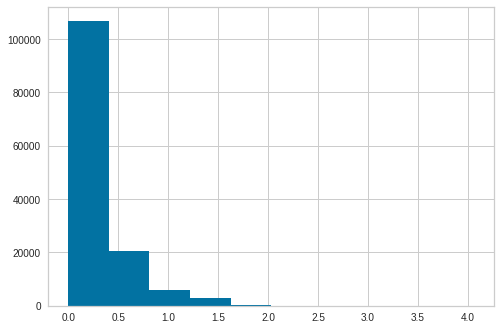

In [65]:
np.log(df['Number_of_Casualties']).hist()

In [67]:
predictors = ['Longitude', 'Police_Force', 'Accident_Severity', 'Number_of_Casualties', 
             'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
             'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
             'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 
             'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
             'Hour']
X = df.dropna().loc[:, predictors]
X['Number_of_Casualties'] = np.log(X['Number_of_Casualties'])
y = df.dropna().loc[:, 'Number_of_Vehicles'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

X_stats = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_stats).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     706.4
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:18:05   Log-Likelihood:            -1.0451e+05
No. Observations:              102585   AIC:                         2.090e+05
Df Residuals:                  102567   BIC:                         2.092e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.3669      0.020     67.071      0.000       1.327       1.407
Longitude                                   0.0087      0.002      5.211      0.000       0.005       0.012
Police_Force                                0.0010      0.000      8.338      0.000       0.001       0.001
Accident_Severity                           0.1484      0.005     29.232      0.000       0.138       0.158
Number_of_Casualties                        0.4642      0.006     83.453      0.000       0.453       0.475
Road_Type                                  -0.0242      0.001    -17.870      0.000      -0.027      -0.022
Speed_limit                                 0.0055      0.000     25.525      0.000       0.005       0.006
Junction_Detail                             0.0152      0.001     12.509      0.000       0.013       0.018
Junction_Control                            0.0093      0.001      7.257      0.000       0.007       0.012
Pedestrian_Crossing-Human_Control          -0.0769      0.014     -5.479      0.000      -0.104      -0.049
Pedestrian_Crossing-Physical_Facilities    -0.0191      0.001    -16.544      0.000      -0.021      -0.017
Light_Conditions                           -0.0290      0.001    -22.102      0.000      -0.032      -0.026
Weather_Conditions                         -0.0074      0.001     -5.932      0.000      -0.010      -0.005
Road_Surface_Conditions                    -0.0494      0.004    -13.230      0.000      -0.057      -0.042
Special_Conditions_at_Site                 -0.0129      0.003     -3.953      0.000      -0.019      -0.007
Carriageway_Hazards                        -0.0384      0.004    -10.010      0.000      -0.046      -0.031
Urban_or_Rural_Area                        -0.0418      0.006     -6.757      0.000      -0.054      -0.030
Hour                                        0.0031      0.000      7.441      0.000       0.002       0.004
==============================================================================
Omnibus:                    38415.132   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           365294.957
Skew:                           1.535   Prob(JB):                         0.00
Kurtosis:                      11.720   Cond. No.                         507.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Scikit-learn

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X, Y)